In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow


100%|██████████| 206M/206M [00:10<00:00, 20.4MB/s]


In [3]:
! nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-d996c994-df89-dbe5-4bd6-7d31ec654036)


In [4]:
! pip install --upgrade ultralytics -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.8/782.8 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.4 MB/s eta 0:00:00


In [5]:
import ultralytics
print(ultralytics.__version__)

8.2.35


In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [7]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = '/content'


In [8]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [9]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/construction-site-safety-image-dataset-roboflow/css-data/test
train: /content/construction-site-safety-image-dataset-roboflow/css-data/train
val: /content/construction-site-safety-image-dataset-roboflow/css-data/valid



In [10]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



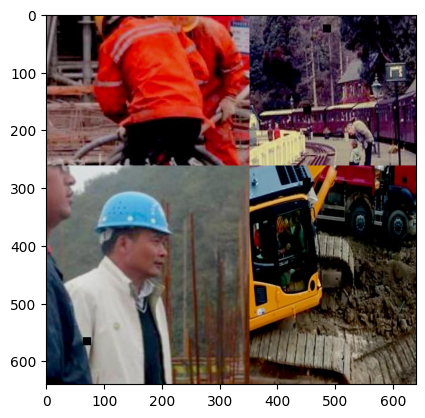

In [11]:
example_image_path = '/content/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [12]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()


In [13]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
plot_random_images_from_folder(folder_path, num_images=20, seed=54)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [15]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [16]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


In [17]:
dataset_stats_df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
Hardhat,3.000000,462.000000,737.878039,30.000000,30.000000,36.000000,37.200000,42.000000,678.000000,805.200000,1314.000000,1314.000000
Mask,3.000000,377.000000,622.674072,16.000000,16.000000,17.500000,17.800000,19.000000,557.500000,665.200000,1096.000000,1096.000000
NO-Hardhat,3.000000,480.666667,778.868624,25.000000,25.000000,31.000000,32.200000,37.000000,708.500000,842.800000,1380.000000,1380.000000
NO-Mask,3.000000,535.000000,862.589705,30.000000,30.000000,37.000000,38.400000,44.000000,787.500000,936.200000,1531.000000,1531.000000
NO-Safety Vest,3.000000,652.000000,1049.670424,36.000000,36.000000,46.000000,48.000000,56.000000,960.000000,1140.800000,1864.000000,1864.000000
Person,3.000000,889.666667,1417.161365,59.000000,59.000000,71.500000,74.000000,84.000000,1305.000000,1549.200000,2526.000000,2526.000000
Safety Cone,3.000000,217.333333,358.254565,8.000000,8.000000,10.500000,11.000000,13.000000,322.000000,383.800000,631.000000,631.000000
Safety Vest,3.000000,456.333333,747.097272,22.000000,22.000000,25.000000,25.600000,28.000000,673.500000,802.600000,1319.000000,1319.000000
machinery,3.000000,716.333333,1199.158177,22.000000,22.000000,24.000000,24.400000,26.000000,1063.500000,1271.000000,2101.000000,2101.000000
vehicle,3.000000,258.333333,420.599968,15.000000,15.000000,15.500000,15.600000,16.000000,380.000000,452.800000,744.000000,744.000000


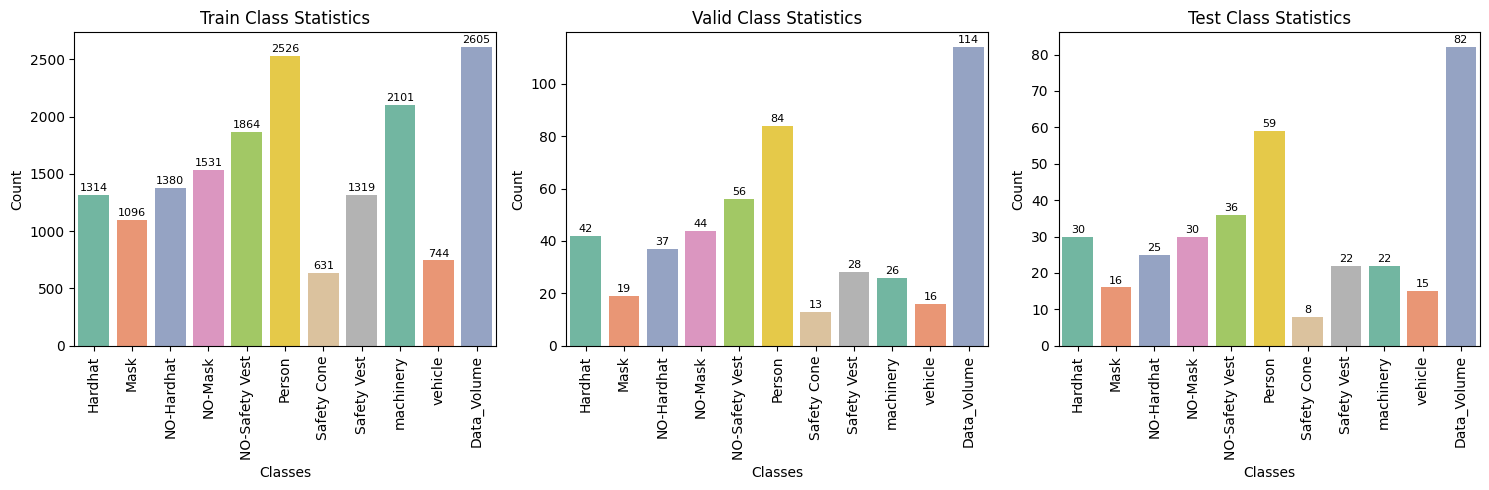

In [18]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [19]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)




In [20]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

In [22]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

# Pass a string with comma-separated device IDs
results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = '0', # Use available GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /content/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 28.4ms
Speed: 5.7ms preprocess, 28.4ms inference, 846.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


In [23]:
import torch

model = YOLO(CFG.BASE_MODEL_WEIGHTS)

# Determine the available devices
devices = [0] if torch.cuda.is_available() else []  # Use GPU 0 if available, otherwise use CPU

results = model.predict(
    source=example_image_path,
    classes=[0],
    conf=0.30,
    device=devices,  # Pass the list of available devices
    imgsz=(img_properties['height'], img_properties['width']),
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True,
)


image 1/1 /content/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 28.3ms
Speed: 1.5ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



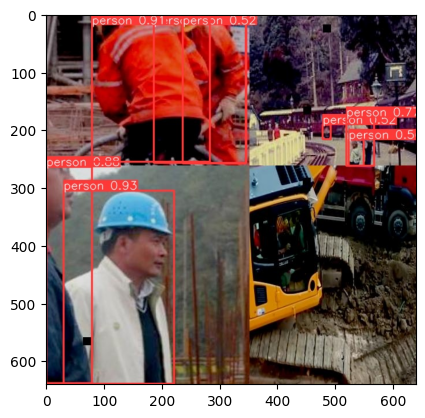

In [24]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

In [25]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  16


In [26]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [27]:
### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0], # Use only the available GPU
    verbose = False,
)

Ultralytics YOLOv8.2.35 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 313MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:02<00:00, 1296.56it/s]

train: WARNING ⚠️ /content/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /content/construction-site-safety-image-dataset-roboflow/css-data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1225.89it/s]

val: New cache created: /content/construction-site-safety-image-dataset-roboflow/css-data/valid/labels.cache


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      22.7G       1.26      1.754      1.497        236        640: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        697      0.474      0.441      0.398      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      21.3G      1.274      1.588      1.508        284        640: 100%|██████████| 163/163 [01:08<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]

                   all        114        697      0.525      0.408      0.406      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      21.3G      1.281      1.557      1.502        271        640: 100%|██████████| 163/163 [01:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        114        697      0.561      0.428      0.409      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      21.3G      1.244       1.49      1.484        272        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        114        697      0.576      0.471      0.477      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      21.3G      1.208      1.406      1.453        271        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        697       0.68      0.543      0.578      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      21.3G      1.151      1.276        1.4        196        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.731      0.589      0.623      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      21.3G      1.123      1.217      1.388        362        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.772      0.596      0.644      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      21.5G      1.103      1.175      1.377        206        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


                   all        114        697      0.792      0.614       0.67      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      20.2G      1.085      1.108      1.349        275        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697       0.73      0.596      0.625      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      21.3G       1.06      1.064      1.332        347        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.775      0.619      0.657      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      21.3G      1.042      1.026      1.321        180        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.788      0.635      0.689      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      21.3G      1.013     0.9705      1.295        247        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697       0.82      0.627      0.696      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      20.2G      1.004     0.9509      1.287        317        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        114        697      0.817      0.663      0.731      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      21.3G     0.9858     0.9207      1.279        253        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.814      0.642      0.725      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      21.3G     0.9826     0.9057      1.268        251        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.836      0.651      0.729      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      21.3G     0.9497     0.8646      1.258        261        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697       0.85       0.67      0.745      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      21.3G     0.9464     0.8452      1.245        349        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        114        697      0.844      0.672      0.734      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      21.3G     0.9329     0.8246      1.245        294        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697       0.84      0.711       0.76      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      21.3G     0.9126     0.8072      1.231        252        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


                   all        114        697      0.876      0.684      0.764      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      21.3G     0.9091     0.7774      1.219        285        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.871      0.673      0.767      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      21.3G     0.8836     0.7542      1.209        326        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.896      0.692      0.774      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      21.3G     0.8731     0.7392      1.196        243        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.859        0.7      0.787      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      21.3G     0.8597     0.7221      1.187        201        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.879      0.713      0.794      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      21.3G     0.8451     0.7048      1.173        412        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.909      0.705      0.794       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      21.3G     0.8396     0.6803       1.17        323        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.846      0.727      0.799      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      21.3G     0.8343     0.6867      1.178        256        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.898      0.689      0.768       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      21.3G     0.8181     0.6714      1.161        321        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.875      0.717      0.781      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      21.3G     0.8112      0.651      1.151        237        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


                   all        114        697      0.881      0.722      0.802      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      21.3G     0.7993     0.6349       1.14        264        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.857      0.736      0.796      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      21.3G     0.7842     0.6278       1.14        200        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.851      0.749      0.804      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      21.3G     0.7778     0.6219      1.136        172        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


                   all        114        697      0.892      0.741      0.821      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      21.3G     0.7644     0.6149      1.122        280        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.889      0.761      0.821      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      21.3G     0.7608      0.595      1.115        226        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


                   all        114        697      0.901      0.733      0.807      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      21.3G     0.7558     0.5954      1.115        204        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        697      0.908       0.73      0.817      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      21.5G     0.7413     0.5769      1.112        135        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.887      0.748      0.817      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      21.5G     0.7425     0.5782       1.11        244        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.906       0.77      0.836      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      21.3G     0.7211     0.5558      1.097        277        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.942      0.754      0.851       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      21.3G     0.7192     0.5537      1.099        258        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.932      0.761      0.846      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      21.3G     0.7125     0.5328      1.085        276        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.926      0.752      0.841      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      21.3G     0.6946     0.5192      1.077        258        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697       0.89       0.77      0.835      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      21.3G     0.6943     0.5228      1.074        267        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.909      0.765       0.85      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      21.3G     0.6859     0.5204      1.073        292        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.926      0.778      0.857      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      21.5G     0.6847     0.5177      1.073        236        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.934      0.767      0.851      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      21.3G     0.6748     0.5008      1.063        284        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.909      0.783      0.847      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      21.3G     0.6621     0.4897      1.057        249        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.897      0.786      0.837      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      21.3G     0.6606     0.4909      1.058        275        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.927      0.784      0.844      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      21.3G     0.6516     0.4816      1.046        316        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.934       0.78      0.861      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      21.3G     0.6418      0.469       1.04        354        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        114        697      0.916      0.794      0.854      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      21.3G      0.639     0.4723      1.037        284        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

                   all        114        697      0.921      0.785      0.857      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      21.3G     0.6276      0.462      1.033        271        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.938      0.801      0.868      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      21.3G     0.6195     0.4522       1.03        239        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]

                   all        114        697       0.93      0.791      0.859      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      20.3G     0.6108     0.4472      1.029        201        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697        0.9      0.815      0.865        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      21.3G     0.6076     0.4424      1.025        328        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.917        0.8      0.854      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      21.3G     0.5942     0.4309       1.02        213        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


                   all        114        697       0.93      0.797      0.867      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      21.3G     0.5927     0.4278      1.018        227        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.925      0.798      0.865      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      21.3G     0.5883      0.421       1.01        238        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697       0.92      0.787      0.863      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      21.5G     0.5747      0.415      1.008        226        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.905      0.797      0.868      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      21.3G     0.5702     0.4075      1.006        338        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.893       0.82      0.864      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      21.3G      0.568     0.4045     0.9997        362        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.918      0.807      0.873      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      21.3G     0.5576     0.3947     0.9949        231        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.48it/s]

                   all        114        697      0.922      0.805      0.875      0.638


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70        20G     0.5523     0.3393     0.9811        160        640: 100%|██████████| 163/163 [01:11<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.922      0.817       0.87      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      21.3G      0.539     0.3311     0.9752        132        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.932      0.806      0.876      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      21.3G     0.5297     0.3228     0.9702        157        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


                   all        114        697      0.908      0.829      0.874      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      21.3G     0.5163     0.3153     0.9635        123        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.921      0.815      0.868      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      21.3G     0.5053     0.3055     0.9563        128        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.931      0.814      0.871       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      21.3G     0.5059     0.3066     0.9522        138        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.926      0.818      0.875      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      21.3G     0.4961     0.3019     0.9487        145        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.947      0.794      0.874      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70        20G     0.4875     0.2956     0.9424        122        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697       0.95      0.794      0.874      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      21.3G     0.4817     0.2904     0.9409        174        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697       0.92      0.815      0.878      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      21.3G     0.4724     0.2856     0.9374        190        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.951      0.797      0.878      0.643

70 epochs completed in 1.384 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.2.35 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


                   all        114        697      0.951      0.798      0.878      0.643
Speed: 0.1ms preprocess, 31.5ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79af1a1df040>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [28]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [29]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.2.35 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 194.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 17.0s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (18.5s)
Results saved to /content/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolo

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

In [30]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

[]

In [31]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [33]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}/runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.26010,1.75420,1.49700,0.47353,0.44125,0.39825,0.18929,2.00020,3.47790,2.1463,0.000237,0.000237,0.000237
1,2,1.27360,1.58810,1.50780,0.52529,0.40751,0.40599,0.18816,2.03950,3.16840,2.2197,0.000468,0.000468,0.000468
2,3,1.28080,1.55680,1.50150,0.56051,0.42820,0.40914,0.18368,2.07530,2.48200,2.1952,0.000692,0.000692,0.000692
3,4,1.24410,1.48990,1.48430,0.57648,0.47093,0.47716,0.20775,2.05850,2.23930,2.2381,0.000684,0.000684,0.000684
4,5,1.20820,1.40610,1.45300,0.67976,0.54310,0.57799,0.28471,1.88510,1.69270,2.0258,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.50591,0.30662,0.95216,0.92628,0.81799,0.87532,0.63050,1.00220,0.50356,1.3136,0.000058,0.000058,0.000058
66,67,0.49614,0.30190,0.94873,0.94670,0.79437,0.87415,0.63337,1.01080,0.51066,1.3233,0.000048,0.000048,0.000048
67,68,0.48755,0.29564,0.94240,0.94958,0.79380,0.87409,0.64113,0.96626,0.49908,1.2889,0.000037,0.000037,0.000037
68,69,0.48172,0.29035,0.94087,0.92031,0.81509,0.87844,0.64153,0.97859,0.49557,1.2934,0.000027,0.000027,0.000027


In [34]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
epoch,70.000000,35.500000,20.351085,1.000000,1.000000,18.250000,21.700000,35.500000,52.750000,56.200000,70.000000,70.000000
train/box_loss,70.000000,0.782812,0.220129,0.472380,0.472380,0.608378,0.635542,0.741925,0.927840,0.983214,1.280800,1.280800
train/cls_loss,70.000000,0.677278,0.344137,0.285550,0.285550,0.443620,0.466860,0.577570,0.820280,0.908728,1.754200,1.754200
train/dfl_loss,70.000000,1.142499,0.154126,0.937390,0.937390,1.025975,1.035680,1.111100,1.241550,1.270280,1.507800,1.507800
metrics/precision(B),70.000000,0.863870,0.099587,0.473530,0.473530,0.846642,0.858544,0.898675,0.922122,0.926072,0.950750,0.950750
metrics/recall(B),70.000000,0.722054,0.098267,0.407510,0.407510,0.676133,0.697782,0.752785,0.794227,0.797514,0.829490,0.829490
metrics/mAP50(B),70.000000,0.784842,0.115447,0.398250,0.398250,0.760985,0.771877,0.828140,0.864155,0.867482,0.878440,0.878440
metrics/mAP50-95(B),70.000000,0.505430,0.126761,0.183680,0.183680,0.436987,0.460038,0.541080,0.613555,0.617802,0.643060,0.643060
val/box_loss,70.000000,1.329499,0.318238,0.966260,0.966260,1.054525,1.082110,1.256100,1.533075,1.569200,2.075300,2.075300
val/cls_loss,70.000000,0.877522,0.567297,0.495570,0.495570,0.554787,0.566032,0.685785,0.927600,1.036340,3.477900,3.477900
